#INTRO:
This introduction is for beginners. If you are new to deep learning and image processing then you should take a moment to read the following statements. Deep learning combines several skills including file path manipulation: working with files rooted in your personal computer, google cloud directories, or even amazon web service bucket directories. Make sure you have the right imports before proceeding. Second, build your skills with matrices. Working with matrices especially tensors means you will be working with high dimensional data/arrays, more than 2d. 3d tensors will be standard, if you can imagine a finite number of 2d planes(i.e. [ : , : , : ]). You will want to make yourself familiar with the skill of manipulating these multi dimensional arrays. This is a necessary and crucial part of modeling. This is the part of modeling that sets training in motion. Since we are using Colab, we are accessing files from a google drive directory. It is important to note that you should have the proper import to access your files. Below you will find the Colab import.

Should you want to process and model this data, you can find it on the UPenn BraTS website. 

Be sure to import all the following libraries meant for MRI and filepath manipulation

In [0]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet nibabel pydicom medpy
!pip install --upgrade --quiet SimpleITK
!pip install pydicom
!pip install medpy

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.


In [0]:
%pylab inline
import nibabel
import pydicom
import medpy
import SimpleITK
from fastai.vision import *
import os

import torch

Populating the interactive namespace from numpy and matplotlib


The following function takes an image as a parameter and shapes the image based on your resolution preferences before it displays the image. In this version from SimpleITK, the image will be on the gray scale. 

In [0]:
def sitk_show(img, title=None, margin=0.0, dpi=60):
    nda = SimpleITK.GetArrayFromImage(img)

    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1], nda.shape[0], 0)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)

    if title:
        plt.title(title)

    plt.show()

This function loads an image by accepting a filepath to the image and returns the array volume and/or SimpleITK image ready for display using their api or just array volumne given the boolean parameter.



In [0]:
def load_vol(path, get_sitk=False):
    path = str(path) #adjust for posix path types.
    sitk_vol = SimpleITK.ReadImage(path)
    vol = SimpleITK.GetArrayFromImage(sitk_vol)
    if get_sitk:
        return (vol, sitk_vol)
    else:
        return vol 

This normalization technique is based on standard techniques in image processing of pixel intensities. Adding the minimum value to the pixel array and dividing by the maximum scales the values. The Resolution of the image does not change much since our minimum values are 0 on the gray scale but the transformation of the pixel intensity to a smaller scale may improve computational efficiency. This says nothing about the consequence of having negative value pixels. The normalization technique is a simplified version of standard pixel normalization.  

In [0]:
def basic_norm(arr):
    a_min = np.min(arr)
    a_max = np.max(arr)

    if a_min==a_max:
        #blank image
        return np.zeros(arr.shape)
    else:
        add_min = arr + a_min
        norm = add_min / a_max
        return norm

Normalize each volumetric array and store in an array where 
s is a slice in a volume or set of brain image slices. 

In [0]:
def slice_norm(vol):
    #normalizes each slice
    return np.array([basic_norm(s) for s in vol])


## plan:
<li>get patient</li>
<li>grab volumes and mask volume</li>
<li>load volumes, split into images</li>
<li>normalize the images and stack</li>
<li>save</li>

This function will seperate training data from testing data in the form of file paths. This code is based on the filepath structure of the folder downloaded from BraTS UPenn website. This function takes the root directory as parameter and collects all pertinent filepaths into a 1d array. We then use list comprehension to return the training and label set with containing string 'OT'.

In [0]:
#separates training data
def grab_mhas(path):
    posix_path = pathlib.Path(path)
    files = np.array([[q for q in p.ls() if '.txt' not in str(q)] for p in pathlib.Path(path).ls()]).ravel()
    return ([f for f in files if 'OT' not in f.name], [f for f in files if 'OT' in f.name])

In [0]:
'''
NOTE: particular to OS. 
      particular to google drive or aws filepath directory.
'''

dpath =  pathlib.Path('./brats_gdrive/BRATS2015_Training/')

This is where we capture all filepaths to patients image files using os.walk, making sure not capture any test files from the 'Testing' directory in the root directory and finally appending to the patients variable. 
Each patient contains 5 image files including T1,T1c,T2,Flair, and OT
OT is the label/mask. The previous 4 files are signal modalities or images based on different mri techniques. But it is important to remember that we are not gathering image files here just patient filepaths that lead us to their image files. 

In [0]:
#fetch file paths
patients = []
for path, dirs, files in os.walk(dpath):
    if 'Testing' not in path: #no masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #ignore data from the wrong year.
                patients.append(os.path.join(path,d))
                
patients[0]

'../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat470_0001'

Using grab_mhas, we display a single patient's modality files

In [0]:
xs, y = grab_mhas(patients[68])
xs

[PosixPath('../brats_gdrive/BRATS2015_Training/HGG/brats_tcia_pat460_0001/VSD.Brain.XX.O.MR_T1c.36553/VSD.Brain.XX.O.MR_T1c.36553.mha'),
 PosixPath('../brats_gdrive/BRATS2015_Training/HGG/brats_tcia_pat460_0001/VSD.Brain.XX.O.MR_T2.36554/VSD.Brain.XX.O.MR_T2.36554.mha'),
 PosixPath('../brats_gdrive/BRATS2015_Training/HGG/brats_tcia_pat460_0001/VSD.Brain.XX.O.MR_T1.36552/VSD.Brain.XX.O.MR_T1.36552.mha'),
 PosixPath('../brats_gdrive/BRATS2015_Training/HGG/brats_tcia_pat460_0001/VSD.Brain.XX.O.MR_Flair.36551/VSD.Brain.XX.O.MR_Flair.36551.mha')]

label file

In [0]:
y

[PosixPath('../brats_gdrive/BRATS2015_Training/HGG/brats_tcia_pat460_0001/VSD.Brain_3more.XX.O.OT.42795/VSD.Brain_3more.XX.O.OT.42795.mha')]

Load volume from xs list of patients

In [0]:
vol, s_vol = load_vol(xs[0], get_sitk=True)
vol.shape

(155, 240, 240)

Display image slice from patient volume

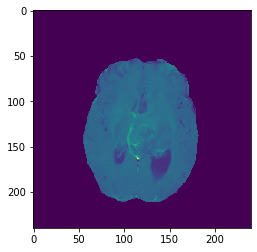

In [0]:
'''
show cross-sectional area:
'''
plt.imshow(vol[75])


### do we want bias correction?


Bias correction may improve modeling results but it is time costly. With big computing power, it would be worthy to apply this function. 

In [0]:
def bias_correct(img, levels=4, its_per_level=60):
    inputImage = SimpleITK.Cast(img, SimpleITK.sitkFloat32 )
    corrector = SimpleITK.N4BiasFieldCorrectionImageFilter()
    numberFittingLevels = levels
    corrector.SetMaximumNumberOfIterations( [ its_per_level ] *numberFittingLevels  )
    output = corrector.Execute(inputImage)
    return output

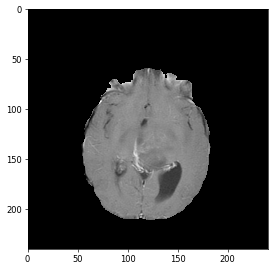

In [0]:
#bias correction is possible, but would take a forever. (time per slice ~ 1 second)
sitk_show(bias_correct(s_vol[:,:,67]))

In [0]:
patients[:10]

['../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat470_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat451_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat266_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat393_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat249_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat177_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat276_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat462_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat413_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat299_0001']

Formatting for display of processing with patient IDs 

In [0]:
'''
format patient IDs
'''

for p in patients[:10]:
    xs, y = grab_mhas(p)

    #grab patient ID from filename
    pid = xs[0].name.split('.')[-2]
    
    print(f'Grabbing PID {pid}')

Grabbing PID 41150
Grabbing PID 41142
Grabbing PID 35889
Grabbing PID 41090
Grabbing PID 35829
Grabbing PID 35673
Grabbing PID 35904
Grabbing PID 41144
Grabbing PID 36279
Grabbing PID 35953


tqdm is a great tool for showing progress of data processing. It can be applied in the for loop statement as an enumerator.

In [0]:
from tqdm import tqdm

In [0]:
patients = []

for path, dirs, files in os.walk(dpath):
    if 'Testing' not in path: #no masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #ignore data from the wrong year
                patients.append(os.path.join(path,d))
                
patients[:10]

['../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat470_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat451_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat266_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat393_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat249_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat177_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat276_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat462_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat413_0001',
 '../brats_gdrive/BRATS2015_Training/LGG/brats_tcia_pat299_0001']

This for loop processes all data one patient at a time. First we grab a filepath to a patient. Then we use grab_mhas to split our image files into training and labels. xs will carry 4 images files at a time and y one image file, the segmentation mask file. Then we normalize each slice in the xs list only. the y label doesn't need to be normalized. It is our ground truth. We have our list of normalized image arrays stored in vols_list and we proceed to load the mask and store it in mask_vol. NOTE: one mask/ground truth file for all 4 image modalities. Next we add the mask_vol to the vols_list and convert the list to an array. We calculate the total number of slices with vols.shape[1] and proceed to enumerate across each slice using tdqm to track our progress to completion. In the for loop we split the array list into separate volumes with all 4 volumes containing 4 dimensions. Dimension 0 has shape 5, and for s=0 or slice=0, we shall gather all pixels across all 4 modalities including the mask. Each image is 240 by 240. The dimensions of the image are are in vols.shape[2] and vols.shape[3]. Next we stack images across all 4 modalities so that the shape of the array is now 240,240,4. Before we write these images as pngs to the directory for final phase modeling, we have to multiply the image pixel in the stack array by 255, to get proper pixel range and cast to uint8, which is appropriate to our 0-255 pixel range. Remember we had previously normalized the data to be between 0 and 1. 


In [0]:
'''
this should generate all the data we need.
'''
for p in patients:
    xs, y = grab_mhas(p)

    #grab patient ID from filename
    pid = xs[0].name.split('.')[-2]

    print(f'Grabbing PID {pid}')

    #run slicewise normalization on each volume
    vols_list = [slice_norm(load_vol(x)) for x in xs]

    #also load the mask volume
    mask_vol = load_vol(y[0])

    #stick everything together
    vols_list.append(mask_vol)
    vols = np.array(vols_list)


    #grab the number of slices.
    n_slices = vols.shape[1]

    #modify output files here:
    for s in tqdm(range(n_slices)):
        a,b,c,d,m = vols[:,s,:,:]#slices vary for all 5 volumes
        stck = np.stack([a,b,c,d], axis=2)#shape 240,240,4
        
        imwrite(f'./brats_png/images/{pid}_{s}.png',(stck[:,:,:3]*255).astype('uint8'))
        imwrite(f'./brats_png/labels/mask_{pid}_{s}.png',(m).astype('uint8')) 

Grabbing PID 41150


100%|██████████| 155/155 [00:01<00:00, 91.88it/s]


Grabbing PID 41142


100%|██████████| 155/155 [00:01<00:00, 82.15it/s]


Grabbing PID 35889


100%|██████████| 155/155 [00:01<00:00, 91.50it/s]


Grabbing PID 41090


100%|██████████| 155/155 [00:01<00:00, 80.17it/s]


Grabbing PID 35829


100%|██████████| 155/155 [00:01<00:00, 83.80it/s]


Grabbing PID 35673


100%|██████████| 155/155 [00:01<00:00, 92.61it/s] 


Grabbing PID 35904


100%|██████████| 155/155 [00:01<00:00, 91.70it/s]


Grabbing PID 41144


100%|██████████| 155/155 [00:01<00:00, 88.50it/s]


Grabbing PID 36279


100%|██████████| 155/155 [00:01<00:00, 84.64it/s]


Grabbing PID 35953


100%|██████████| 155/155 [00:01<00:00, 80.85it/s]


Grabbing PID 41044


100%|██████████| 155/155 [00:01<00:00, 92.26it/s]


Grabbing PID 41105


100%|██████████| 155/155 [00:01<00:00, 88.64it/s]


Grabbing PID 36601


100%|██████████| 155/155 [00:01<00:00, 84.27it/s]


Grabbing PID 35532


100%|██████████| 155/155 [00:01<00:00, 85.94it/s]


Grabbing PID 41026


100%|██████████| 155/155 [00:01<00:00, 89.18it/s] 


Grabbing PID 36008


100%|██████████| 155/155 [00:01<00:00, 87.57it/s]


Grabbing PID 40825


100%|██████████| 155/155 [00:01<00:00, 81.34it/s]


Grabbing PID 41152


100%|██████████| 155/155 [00:02<00:00, 74.47it/s]


Grabbing PID 41066


100%|██████████| 155/155 [00:01<00:00, 90.39it/s]


Grabbing PID 40934


100%|██████████| 155/155 [00:01<00:00, 82.64it/s]


Grabbing PID 35950


100%|██████████| 155/155 [00:01<00:00, 83.93it/s]


Grabbing PID 35982


100%|██████████| 155/155 [00:01<00:00, 87.05it/s]


Grabbing PID 36048


100%|██████████| 155/155 [00:01<00:00, 84.78it/s]


Grabbing PID 40832


100%|██████████| 155/155 [00:01<00:00, 91.96it/s]


Grabbing PID 36509


100%|██████████| 155/155 [00:01<00:00, 84.40it/s]


Grabbing PID 35590


100%|██████████| 155/155 [00:01<00:00, 82.64it/s]


Grabbing PID 40877


100%|██████████| 155/155 [00:01<00:00, 81.00it/s]


Grabbing PID 36562


100%|██████████| 155/155 [00:01<00:00, 80.83it/s]


Grabbing PID 36541


100%|██████████| 155/155 [00:01<00:00, 90.59it/s]


Grabbing PID 35845


100%|██████████| 155/155 [00:02<00:00, 71.07it/s]


Grabbing PID 41093


100%|██████████| 155/155 [00:01<00:00, 86.43it/s]


Grabbing PID 36598


100%|██████████| 155/155 [00:02<00:00, 73.87it/s]


Grabbing PID 36609


100%|██████████| 155/155 [00:01<00:00, 90.61it/s]


Grabbing PID 35840


100%|██████████| 155/155 [00:01<00:00, 83.65it/s]


Grabbing PID 41043


100%|██████████| 155/155 [00:01<00:00, 87.05it/s]


Grabbing PID 40940


100%|██████████| 155/155 [00:01<00:00, 87.98it/s]


Grabbing PID 41103


100%|██████████| 155/155 [00:02<00:00, 76.49it/s]


Grabbing PID 40943


100%|██████████| 155/155 [00:01<00:00, 81.39it/s]


Grabbing PID 40972


100%|██████████| 155/155 [00:01<00:00, 83.78it/s] 


Grabbing PID 40835


100%|██████████| 155/155 [00:01<00:00, 84.23it/s]


Grabbing PID 36246


100%|██████████| 155/155 [00:01<00:00, 79.93it/s]


Grabbing PID 35721


100%|██████████| 155/155 [00:01<00:00, 84.77it/s]


Grabbing PID 36308


100%|██████████| 155/155 [00:01<00:00, 84.86it/s]


Grabbing PID 40821


100%|██████████| 155/155 [00:01<00:00, 83.42it/s]


Grabbing PID 41097


100%|██████████| 155/155 [00:01<00:00, 88.62it/s]


Grabbing PID 35533


100%|██████████| 155/155 [00:01<00:00, 86.20it/s]


Grabbing PID 35821


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 155/155 [00:02<00:00, 77.19it/s]


Grabbing PID 35860


100%|██████████| 155/155 [00:01<00:00, 83.32it/s]


Grabbing PID 36314


100%|██████████| 155/155 [00:01<00:00, 82.75it/s]


Grabbing PID 35754


100%|██████████| 155/155 [00:01<00:00, 81.10it/s]


Grabbing PID 36083


100%|██████████| 155/155 [00:01<00:00, 79.14it/s]


Grabbing PID 36070


100%|██████████| 155/155 [00:01<00:00, 86.72it/s]


Grabbing PID 36521


100%|██████████| 155/155 [00:01<00:00, 84.26it/s]


Grabbing PID 35757


100%|██████████| 155/155 [00:01<00:00, 87.51it/s]


Grabbing PID 40985


100%|██████████| 155/155 [00:02<00:00, 72.08it/s]


Grabbing PID 36112


100%|██████████| 155/155 [00:01<00:00, 92.54it/s]


Grabbing PID 36563


100%|██████████| 155/155 [00:01<00:00, 82.51it/s]


Grabbing PID 35907


100%|██████████| 155/155 [00:01<00:00, 84.15it/s]


Grabbing PID 35610


100%|██████████| 155/155 [00:01<00:00, 78.51it/s]


Grabbing PID 40897


100%|██████████| 155/155 [00:01<00:00, 83.19it/s]


Grabbing PID 35575


100%|██████████| 155/155 [00:01<00:00, 85.14it/s]


Grabbing PID 35561


100%|██████████| 155/155 [00:01<00:00, 88.80it/s]


Grabbing PID 36136


100%|██████████| 155/155 [00:01<00:00, 90.68it/s]


Grabbing PID 36231


100%|██████████| 155/155 [00:01<00:00, 78.97it/s]


Grabbing PID 35675


100%|██████████| 155/155 [00:01<00:00, 85.41it/s]


Grabbing PID 36578


100%|██████████| 155/155 [00:01<00:00, 98.18it/s] 


Grabbing PID 36558


100%|██████████| 155/155 [00:01<00:00, 94.49it/s]


Grabbing PID 36218


100%|██████████| 155/155 [00:01<00:00, 84.06it/s]


Grabbing PID 36553


100%|██████████| 155/155 [00:01<00:00, 79.87it/s]


Grabbing PID 36139


100%|██████████| 155/155 [00:01<00:00, 83.72it/s]


Grabbing PID 35627


100%|██████████| 155/155 [00:01<00:00, 77.93it/s]


Grabbing PID 36016


100%|██████████| 155/155 [00:01<00:00, 95.86it/s]


Grabbing PID 36105


100%|██████████| 155/155 [00:01<00:00, 92.05it/s]


Grabbing PID 41132


100%|██████████| 155/155 [00:02<00:00, 73.42it/s]


Grabbing PID 41007


100%|██████████| 155/155 [00:02<00:00, 73.76it/s]


Grabbing PID 36594


100%|██████████| 155/155 [00:01<00:00, 92.76it/s]


Grabbing PID 36567


100%|██████████| 155/155 [00:01<00:00, 77.78it/s]


Grabbing PID 35870


100%|██████████| 155/155 [00:01<00:00, 88.34it/s]


Grabbing PID 36603


100%|██████████| 155/155 [00:02<00:00, 74.74it/s]


Grabbing PID 36285


100%|██████████| 155/155 [00:01<00:00, 87.73it/s]


Grabbing PID 35661


100%|██████████| 155/155 [00:01<00:00, 77.70it/s]


Grabbing PID 41636


100%|██████████| 155/155 [00:01<00:00, 88.65it/s]


Grabbing PID 36252


100%|██████████| 155/155 [00:01<00:00, 82.68it/s]


Grabbing PID 41055


100%|██████████| 155/155 [00:01<00:00, 92.42it/s] 


Grabbing PID 36440


100%|██████████| 155/155 [00:01<00:00, 80.95it/s]


Grabbing PID 35620


100%|██████████| 155/155 [00:01<00:00, 86.01it/s]


Grabbing PID 36143


100%|██████████| 155/155 [00:01<00:00, 87.71it/s]


Grabbing PID 36060


100%|██████████| 155/155 [00:01<00:00, 84.58it/s]


Grabbing PID 35678


100%|██████████| 155/155 [00:01<00:00, 81.09it/s]


Grabbing PID 35683


100%|██████████| 155/155 [00:01<00:00, 88.99it/s]


Grabbing PID 36028


100%|██████████| 155/155 [00:01<00:00, 92.35it/s]


Grabbing PID 35925


100%|██████████| 155/155 [00:01<00:00, 89.98it/s] 


Grabbing PID 36299


100%|██████████| 155/155 [00:01<00:00, 85.09it/s] 


Grabbing PID 35792


100%|██████████| 155/155 [00:02<00:00, 71.14it/s]


Grabbing PID 41031


100%|██████████| 155/155 [00:01<00:00, 78.97it/s]


Grabbing PID 40928


100%|██████████| 155/155 [00:01<00:00, 78.09it/s]


Grabbing PID 36205


100%|██████████| 155/155 [00:01<00:00, 81.83it/s]


Grabbing PID 36204


100%|██████████| 155/155 [00:02<00:00, 76.59it/s]


Grabbing PID 35886


100%|██████████| 155/155 [00:01<00:00, 89.92it/s]


Grabbing PID 35776


100%|██████████| 155/155 [00:02<00:00, 69.97it/s]


Grabbing PID 36091


100%|██████████| 155/155 [00:01<00:00, 83.97it/s]


Grabbing PID 35724


100%|██████████| 155/155 [00:01<00:00, 81.51it/s]


Grabbing PID 35858


100%|██████████| 155/155 [00:01<00:00, 84.78it/s]


Grabbing PID 36093


100%|██████████| 155/155 [00:01<00:00, 87.19it/s]


Grabbing PID 57800


100%|██████████| 155/155 [00:01<00:00, 79.82it/s]


Grabbing PID 35658


100%|██████████| 155/155 [00:01<00:00, 85.95it/s]


Grabbing PID 35693


100%|██████████| 155/155 [00:01<00:00, 85.66it/s]


Grabbing PID 40987


100%|██████████| 155/155 [00:01<00:00, 78.42it/s]


Grabbing PID 40998


100%|██████████| 155/155 [00:01<00:00, 85.43it/s]


Grabbing PID 41021


100%|██████████| 155/155 [00:01<00:00, 85.21it/s]


Grabbing PID 36168


100%|██████████| 155/155 [00:02<00:00, 73.11it/s]


Grabbing PID 40872


100%|██████████| 155/155 [00:01<00:00, 80.76it/s]


Grabbing PID 35633


100%|██████████| 155/155 [00:02<00:00, 76.37it/s]


Grabbing PID 35552


100%|██████████| 155/155 [00:01<00:00, 80.86it/s]


Grabbing PID 35565


100%|██████████| 155/155 [00:01<00:00, 79.70it/s]


Grabbing PID 35617


100%|██████████| 155/155 [00:01<00:00, 81.64it/s]


Grabbing PID 36289


100%|██████████| 155/155 [00:02<00:00, 74.41it/s]


Grabbing PID 35638


100%|██████████| 155/155 [00:01<00:00, 80.79it/s]


Grabbing PID 35803


100%|██████████| 155/155 [00:01<00:00, 87.61it/s]


Grabbing PID 35598


100%|██████████| 155/155 [00:01<00:00, 82.35it/s]


Grabbing PID 35997


100%|██████████| 155/155 [00:01<00:00, 85.43it/s]


Grabbing PID 35602


100%|██████████| 155/155 [00:02<00:00, 77.49it/s]


Grabbing PID 36009


100%|██████████| 155/155 [00:01<00:00, 84.80it/s]


Grabbing PID 40860


100%|██████████| 155/155 [00:01<00:00, 86.26it/s]


Grabbing PID 35708


100%|██████████| 155/155 [00:01<00:00, 91.03it/s]


Grabbing PID 40903


100%|██████████| 155/155 [00:02<00:00, 76.58it/s]


Grabbing PID 35651


100%|██████████| 155/155 [00:01<00:00, 86.94it/s]


Grabbing PID 36321


100%|██████████| 155/155 [00:01<00:00, 78.71it/s]


Grabbing PID 36103


100%|██████████| 155/155 [00:01<00:00, 92.97it/s]


Grabbing PID 35580


100%|██████████| 155/155 [00:01<00:00, 82.41it/s]


Grabbing PID 35736


100%|██████████| 155/155 [00:01<00:00, 79.45it/s]


Grabbing PID 36616


100%|██████████| 155/155 [00:01<00:00, 79.81it/s]


Grabbing PID 36018


100%|██████████| 155/155 [00:01<00:00, 85.28it/s]


Grabbing PID 35850


100%|██████████| 155/155 [00:01<00:00, 78.23it/s]


Grabbing PID 35901


100%|██████████| 155/155 [00:02<00:00, 76.05it/s]


Grabbing PID 40979


100%|██████████| 155/155 [00:01<00:00, 84.09it/s]


Grabbing PID 35910


100%|██████████| 155/155 [00:01<00:00, 80.58it/s]


Grabbing PID 36233


100%|██████████| 155/155 [00:01<00:00, 86.68it/s]


Grabbing PID 35933


100%|██████████| 155/155 [00:01<00:00, 82.41it/s]


Grabbing PID 36078


100%|██████████| 155/155 [00:01<00:00, 88.97it/s]


Grabbing PID 36151


100%|██████████| 155/155 [00:02<00:00, 76.76it/s]


Grabbing PID 40958


100%|██████████| 155/155 [00:01<00:00, 96.01it/s]


Grabbing PID 36215


100%|██████████| 155/155 [00:01<00:00, 77.59it/s]


Grabbing PID 36533


100%|██████████| 155/155 [00:01<00:00, 86.34it/s]


Grabbing PID 41237


100%|██████████| 155/155 [00:02<00:00, 65.30it/s]


Grabbing PID 41113


100%|██████████| 155/155 [00:01<00:00, 86.05it/s]


Grabbing PID 41119


100%|██████████| 155/155 [00:01<00:00, 84.17it/s]


Grabbing PID 35995


100%|██████████| 155/155 [00:01<00:00, 78.81it/s]


Grabbing PID 36546


100%|██████████| 155/155 [00:01<00:00, 84.58it/s]


Grabbing PID 35805


100%|██████████| 155/155 [00:01<00:00, 79.22it/s]


Grabbing PID 36537


100%|██████████| 155/155 [00:01<00:00, 89.53it/s]


Grabbing PID 36097


100%|██████████| 155/155 [00:02<00:00, 73.94it/s]


Grabbing PID 35554


100%|██████████| 155/155 [00:01<00:00, 88.44it/s]


Grabbing PID 36589


100%|██████████| 155/155 [00:02<00:00, 75.23it/s]


Grabbing PID 36582


100%|██████████| 155/155 [00:01<00:00, 77.92it/s]


Grabbing PID 36181


100%|██████████| 155/155 [00:01<00:00, 84.43it/s]


Grabbing PID 36574


100%|██████████| 155/155 [00:01<00:00, 86.27it/s] 


Grabbing PID 40977


100%|██████████| 155/155 [00:01<00:00, 81.65it/s]


Grabbing PID 36243


100%|██████████| 155/155 [00:01<00:00, 81.06it/s]


Grabbing PID 36162


100%|██████████| 155/155 [00:01<00:00, 91.73it/s]


Grabbing PID 40935


100%|██████████| 155/155 [00:01<00:00, 81.43it/s]


Grabbing PID 36274


100%|██████████| 155/155 [00:01<00:00, 78.90it/s]


Grabbing PID 36157


100%|██████████| 155/155 [00:01<00:00, 84.13it/s] 


Grabbing PID 40864


100%|██████████| 155/155 [00:02<00:00, 76.03it/s]


Grabbing PID 40964


100%|██████████| 155/155 [00:01<00:00, 80.69it/s]


Grabbing PID 40910


100%|██████████| 155/155 [00:01<00:00, 88.17it/s]


Grabbing PID 35666


100%|██████████| 155/155 [00:01<00:00, 82.93it/s]


Grabbing PID 40849


100%|██████████| 155/155 [00:01<00:00, 86.49it/s]


Grabbing PID 35732


100%|██████████| 155/155 [00:01<00:00, 89.17it/s]


Grabbing PID 36283


100%|██████████| 155/155 [00:01<00:00, 89.89it/s]


Grabbing PID 36074


100%|██████████| 155/155 [00:01<00:00, 82.81it/s]


Grabbing PID 36222


100%|██████████| 155/155 [00:01<00:00, 83.20it/s]


Grabbing PID 36173


100%|██████████| 155/155 [00:02<00:00, 77.45it/s]


Grabbing PID 35760


100%|██████████| 155/155 [00:01<00:00, 83.80it/s]


Grabbing PID 35644


100%|██████████| 155/155 [00:01<00:00, 80.83it/s]


Grabbing PID 36527


100%|██████████| 155/155 [00:01<00:00, 86.93it/s]


Grabbing PID 36623


100%|██████████| 155/155 [00:01<00:00, 78.54it/s]


Grabbing PID 40919


100%|██████████| 155/155 [00:01<00:00, 87.61it/s]


Grabbing PID 35539


100%|██████████| 155/155 [00:01<00:00, 93.93it/s]


Grabbing PID 35544


100%|██████████| 155/155 [00:01<00:00, 86.44it/s]


Grabbing PID 41126


100%|██████████| 155/155 [00:02<00:00, 76.63it/s]


Grabbing PID 36193


100%|██████████| 155/155 [00:01<00:00, 81.53it/s]


Grabbing PID 40890


100%|██████████| 155/155 [00:01<00:00, 87.03it/s]


Grabbing PID 40926


100%|██████████| 155/155 [00:01<00:00, 91.13it/s]


Grabbing PID 35613


100%|██████████| 155/155 [00:01<00:00, 84.78it/s]


Grabbing PID 35698


100%|██████████| 155/155 [00:01<00:00, 80.04it/s] 


Grabbing PID 40993


100%|██████████| 155/155 [00:01<00:00, 80.87it/s]


Grabbing PID 36513


100%|██████████| 155/155 [00:01<00:00, 82.71it/s]


Grabbing PID 35647


100%|██████████| 155/155 [00:01<00:00, 91.62it/s]


Grabbing PID 35947


100%|██████████| 155/155 [00:02<00:00, 70.18it/s]


Grabbing PID 35959


100%|██████████| 155/155 [00:02<00:00, 77.39it/s]


Grabbing PID 36003


100%|██████████| 155/155 [00:01<00:00, 80.98it/s]


Grabbing PID 41129


100%|██████████| 155/155 [00:02<00:00, 76.81it/s]


Grabbing PID 40968


100%|██████████| 155/155 [00:01<00:00, 79.52it/s]


Grabbing PID 36263


100%|██████████| 155/155 [00:01<00:00, 86.14it/s]


Grabbing PID 40855


100%|██████████| 155/155 [00:01<00:00, 82.16it/s]


Grabbing PID 40918


100%|██████████| 155/155 [00:01<00:00, 89.58it/s]


Grabbing PID 40846


100%|██████████| 155/155 [00:01<00:00, 84.35it/s]


Grabbing PID 35710


100%|██████████| 155/155 [00:01<00:00, 81.52it/s]


Grabbing PID 35548


100%|██████████| 155/155 [00:01<00:00, 85.73it/s]


Grabbing PID 35730


100%|██████████| 155/155 [00:01<00:00, 79.59it/s]


Grabbing PID 40950


100%|██████████| 155/155 [00:01<00:00, 81.15it/s]


Grabbing PID 36125


100%|██████████| 155/155 [00:01<00:00, 92.17it/s]


Grabbing PID 36120


100%|██████████| 155/155 [00:01<00:00, 89.21it/s]


Grabbing PID 36522


100%|██████████| 155/155 [00:01<00:00, 82.11it/s]


Grabbing PID 41039


100%|██████████| 155/155 [00:01<00:00, 79.01it/s]


Grabbing PID 41137


100%|██████████| 155/155 [00:01<00:00, 78.96it/s]


Grabbing PID 41080


100%|██████████| 155/155 [00:01<00:00, 79.24it/s]


Grabbing PID 36269


100%|██████████| 155/155 [00:01<00:00, 85.43it/s]


Grabbing PID 35872


100%|██████████| 155/155 [00:01<00:00, 92.90it/s]


Grabbing PID 41058


100%|██████████| 155/155 [00:01<00:00, 81.53it/s]


Grabbing PID 41060


100%|██████████| 155/155 [00:01<00:00, 89.38it/s]


Grabbing PID 36133


100%|██████████| 155/155 [00:01<00:00, 84.52it/s]


Grabbing PID 35593


100%|██████████| 155/155 [00:01<00:00, 81.76it/s]


Grabbing PID 40882


100%|██████████| 155/155 [00:01<00:00, 81.92it/s]


Grabbing PID 35687


100%|██████████| 155/155 [00:01<00:00, 79.20it/s]


Grabbing PID 35789


100%|██████████| 155/155 [00:02<00:00, 75.43it/s]


Grabbing PID 35557


100%|██████████| 155/155 [00:01<00:00, 78.23it/s]


Grabbing PID 36295


100%|██████████| 155/155 [00:01<00:00, 95.90it/s]


Grabbing PID 40851


100%|██████████| 155/155 [00:01<00:00, 85.89it/s]


Grabbing PID 35623


100%|██████████| 155/155 [00:02<00:00, 74.01it/s]


Grabbing PID 40828


100%|██████████| 155/155 [00:01<00:00, 90.39it/s]


Grabbing PID 36086


100%|██████████| 155/155 [00:01<00:00, 91.83it/s]


Grabbing PID 35715


100%|██████████| 155/155 [00:01<00:00, 80.04it/s]


Grabbing PID 36211


100%|██████████| 155/155 [00:01<00:00, 83.44it/s]


Grabbing PID 35641


100%|██████████| 155/155 [00:02<00:00, 76.31it/s]


Grabbing PID 36503


100%|██████████| 155/155 [00:01<00:00, 92.75it/s]


Grabbing PID 36033


100%|██████████| 155/155 [00:01<00:00, 82.45it/s]


Grabbing PID 36225


100%|██████████| 155/155 [00:01<00:00, 81.73it/s]


Grabbing PID 40841


100%|██████████| 155/155 [00:01<00:00, 84.47it/s]


Grabbing PID 41116


100%|██████████| 155/155 [00:01<00:00, 80.86it/s]


Grabbing PID 36189


100%|██████████| 155/155 [00:01<00:00, 77.91it/s]


Grabbing PID 36188


100%|██████████| 155/155 [00:01<00:00, 84.59it/s]


Grabbing PID 36052


100%|██████████| 155/155 [00:01<00:00, 82.15it/s]


Grabbing PID 35696


100%|██████████| 155/155 [00:01<00:00, 88.37it/s]


Grabbing PID 36200


100%|██████████| 155/155 [00:01<00:00, 79.77it/s]


Grabbing PID 35854


100%|██████████| 155/155 [00:01<00:00, 80.88it/s]


Grabbing PID 35799


100%|██████████| 155/155 [00:02<00:00, 69.65it/s]


Grabbing PID 36177


100%|██████████| 155/155 [00:01<00:00, 83.34it/s]


Grabbing PID 35811


100%|██████████| 155/155 [00:01<00:00, 87.90it/s]


Grabbing PID 36315


100%|██████████| 155/155 [00:01<00:00, 88.85it/s]


Grabbing PID 35866


100%|██████████| 155/155 [00:01<00:00, 91.24it/s]


Grabbing PID 35603


100%|██████████| 155/155 [00:01<00:00, 86.29it/s]


Grabbing PID 35927


100%|██████████| 155/155 [00:01<00:00, 81.33it/s]


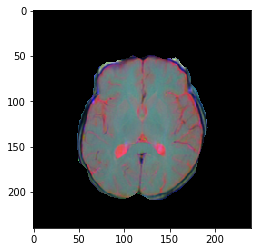

In [0]:
'''
Show stck cross-section.
'''

s = 75
a,b,c,d,m = vols[:,s,:,:]
stck = np.stack([a,b,c,d], axis=2)
plt.imshow(stck[:,:,:3])

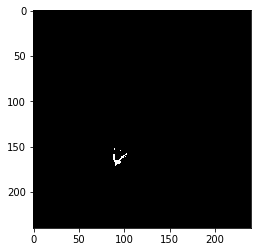

In [0]:
plt.imshow(vols[4,72,:,:])